# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



## Идеи

### Аугментация


[X] Хочется увеличить количество данных. Поэтому флип, ротате, увеличения яркостей

[ ] Сделать одинкаовое количество фоточек во всех классах через аугментации

### Кроссвалидация

[ ] Сделать вместо разделения на train, valid, кроссвалидацию и сохранить ансамблем.


### Модели

[X] ResNet18 с заморозкой первых слоев

[ ] ResNet с ограничением обучения первых слоев


## Загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c journey-springfield

In [4]:
!unzip journey-springfield.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1039.jpg  
  in

## Работа с датасетом

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch
torch.cuda.is_available()

from matplotlib import colors, pyplot as plt
%matplotlib inline


Для воспроизводимости

In [6]:
import torch
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)                  # Python
    np.random.seed(seed)               # Numpy
    torch.manual_seed(seed)            # PyTorch CPU
    torch.cuda.manual_seed(seed)       # PyTorch GPU
    torch.backends.cudnn.deterministic = True  # Для детерминированности на CUDA
    torch.backends.cudnn.benchmark = False     # Для воспроизводимости

set_seed(42)

In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Добавим аугментации для train к кастомному классу датасета:

- Случайный crop вместо детерминированного
- случайный поворот на 25 градусов
- случайный флип

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
      # Выбираем нужную трансформацию
      if self.mode == "train":
          transform = transforms.Compose([
              transforms.RandomHorizontalFlip(),
              # transforms.RandomRotation(25),
              # transforms.RandomResizedCrop(RESCALE_SIZE),
              # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

      # Загружаем изображение
      x = self.load_sample(self.files[index])
      # Применяем подготовку (например, изменение размера)
      x = self._prepare_sample(x)  # сейчас x — numpy.ndarray
      # Преобразуем обратно в PIL.Image
      x = Image.fromarray(x)
      # Применяем цепочку трансформаций
      x = transform(x)
      # print(x)

      if self.mode == 'test':
          return x
      else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y


    def _prepare_sample(self, image):
      image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
      return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')

In [11]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

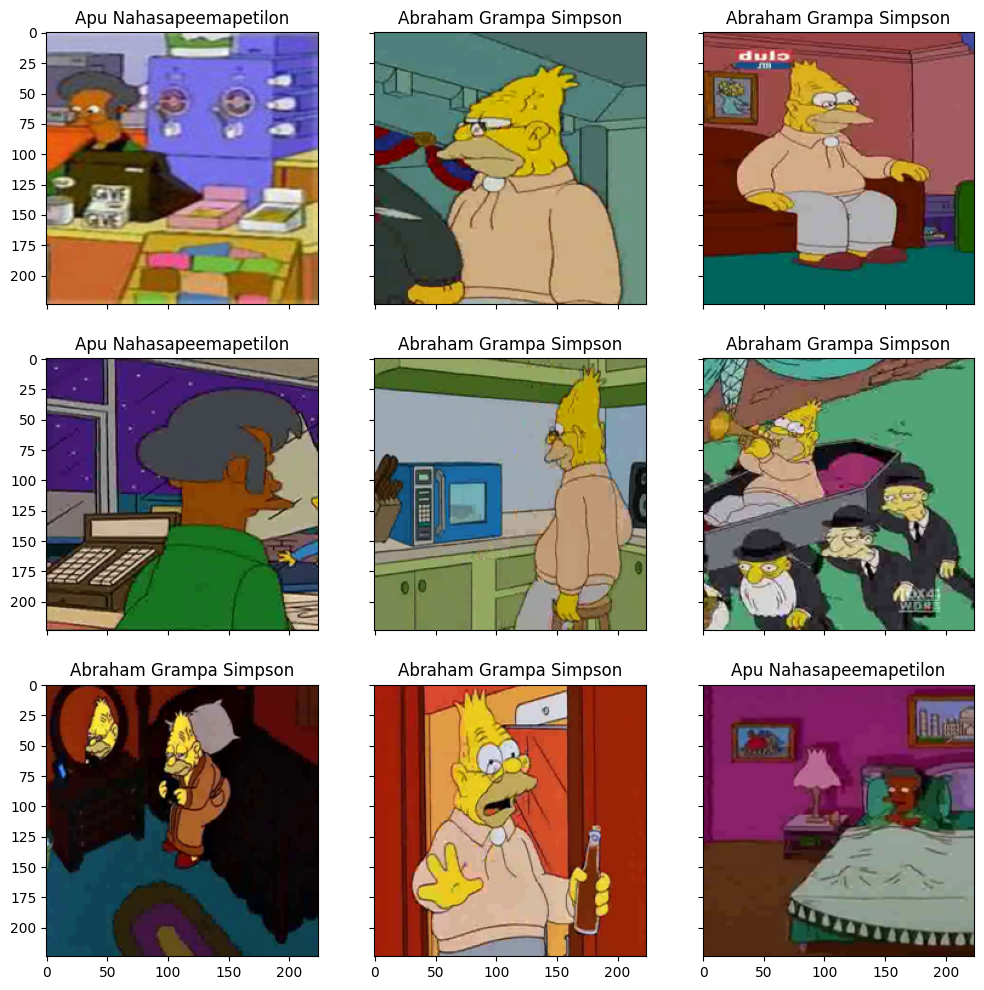

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Дополнительные функции для обучения

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc



def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history



def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## ResNet18


Будем пробовать с resnet18. Первые слои заморозим, оставим последний слой для обучения. Напишем отдельным классом.

In [16]:
models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
class SimpsonsResNet18(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.base_model = models.resnet18(pretrained=True)

    # заморозка параметров
    for param in self.base_model.parameters():
      param.requires_grad = False

    # разморозка последнего блока
    for param in self.base_model.layer4.parameters():
      param.requires_grad = True

    # замена последнего блока на нужный классификатор
    in_features = self.base_model.fc.in_features
    self.base_model.fc = nn.Linear(in_features, n_classes)


  def forward(self, x):
    return self.base_model(x)

### Обучение

In [18]:
# np.count(val_dataset.labels)
import pandas as pd

tmp = np.unique_counts(val_dataset.labels)
pd.DataFrame({
    "name": tmp.values,
    "count": tmp.counts
}).sort_values("count")

,name,count
19,lionel_hutz,1
10,disco_stu,2
40,troy_mcclure,2
26,miss_hoover,4
13,gil,7
12,fat_tony,7
30,otto_mann,8
1,agnes_skinner,10
38,sideshow_mel,10
34,rainier_wolfcastle,11


In [19]:
n_classes = len(np.unique(val_dataset.labels))


model = SimpsonsResNet18(n_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Оптимизатор Adam с аналогом L2 штрафа. Для batch norm не нужно использовать его

In [20]:
decay = []
no_decay = []

for name, param in model.named_parameters():
    if param.requires_grad:  # учитываем только обучаемые параметры
        # Проверяем, есть ли в имени параметра 'bn' или '.bias'
        if ('bn' in name) or ('.bias' in name):
            no_decay.append(param)
        else:
            decay.append(param)

# Теперь объявляем AdamW c двумя группами параметров
optimizer = torch.optim.AdamW([
    {"params": decay, "weight_decay": 1e-2},   # здесь используем weight_decay
    {"params": no_decay, "weight_decay": 0.0}, # здесь отключаем weight_decay
], lr=1e-3)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
history = train(train_dataset,
                val_dataset,
                model=model.to(DEVICE),
                epochs=10,
                batch_size=1024)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.202750155368241


epoch:  10%|█         | 1/10 [02:17<20:38, 137.66s/it]


Epoch 001 train_loss: 1.2028     val_loss 0.5001 train_acc 0.7281 val_acc 0.8863
loss 2.2540962854170696


epoch:  20%|██        | 2/10 [04:28<17:49, 133.72s/it]


Epoch 002 train_loss: 2.2541     val_loss 2.7937 train_acc 0.4589 val_acc 0.2501
loss 2.750969607235178


epoch:  30%|███       | 3/10 [06:39<15:28, 132.62s/it]


Epoch 003 train_loss: 2.7510     val_loss 2.7636 train_acc 0.2622 val_acc 0.2736
loss 2.6542220355462205


epoch:  40%|████      | 4/10 [08:50<13:11, 131.95s/it]


Epoch 004 train_loss: 2.6542     val_loss 3.0382 train_acc 0.2722 val_acc 0.1683
loss 2.255208317227664


epoch:  50%|█████     | 5/10 [11:01<10:58, 131.62s/it]


Epoch 005 train_loss: 2.2552     val_loss 1.5127 train_acc 0.3751 val_acc 0.6045
loss 1.0763314740886671


epoch:  60%|██████    | 6/10 [13:12<08:45, 131.33s/it]


Epoch 006 train_loss: 1.0763     val_loss 0.7445 train_acc 0.7262 val_acc 0.8158
loss 0.6069437933599154


epoch:  70%|███████   | 7/10 [15:23<06:33, 131.15s/it]


Epoch 007 train_loss: 0.6069     val_loss 0.5262 train_acc 0.8448 val_acc 0.8624
loss 0.420310531710658


epoch:  80%|████████  | 8/10 [17:34<04:22, 131.04s/it]


Epoch 008 train_loss: 0.4203     val_loss 0.3921 train_acc 0.8915 val_acc 0.8978
loss 0.3163466166843236


epoch:  90%|█████████ | 9/10 [19:45<02:10, 130.97s/it]


Epoch 009 train_loss: 0.3163     val_loss 0.3467 train_acc 0.9147 val_acc 0.9123
loss 0.23960823605349735


epoch: 100%|██████████| 10/10 [21:56<00:00, 131.61s/it]


Epoch 010 train_loss: 0.2396     val_loss 0.3180 train_acc 0.9352 val_acc 0.9186


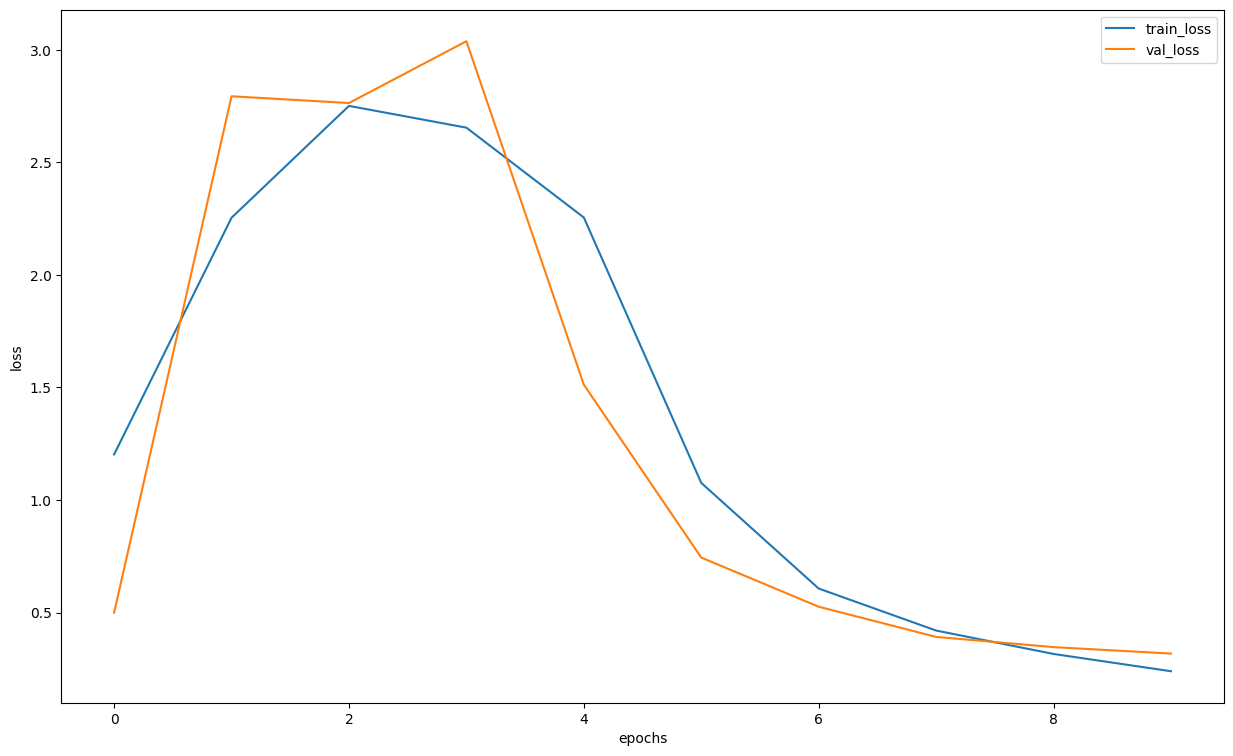

In [24]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [26]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [27]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [28]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [29]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


In [31]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

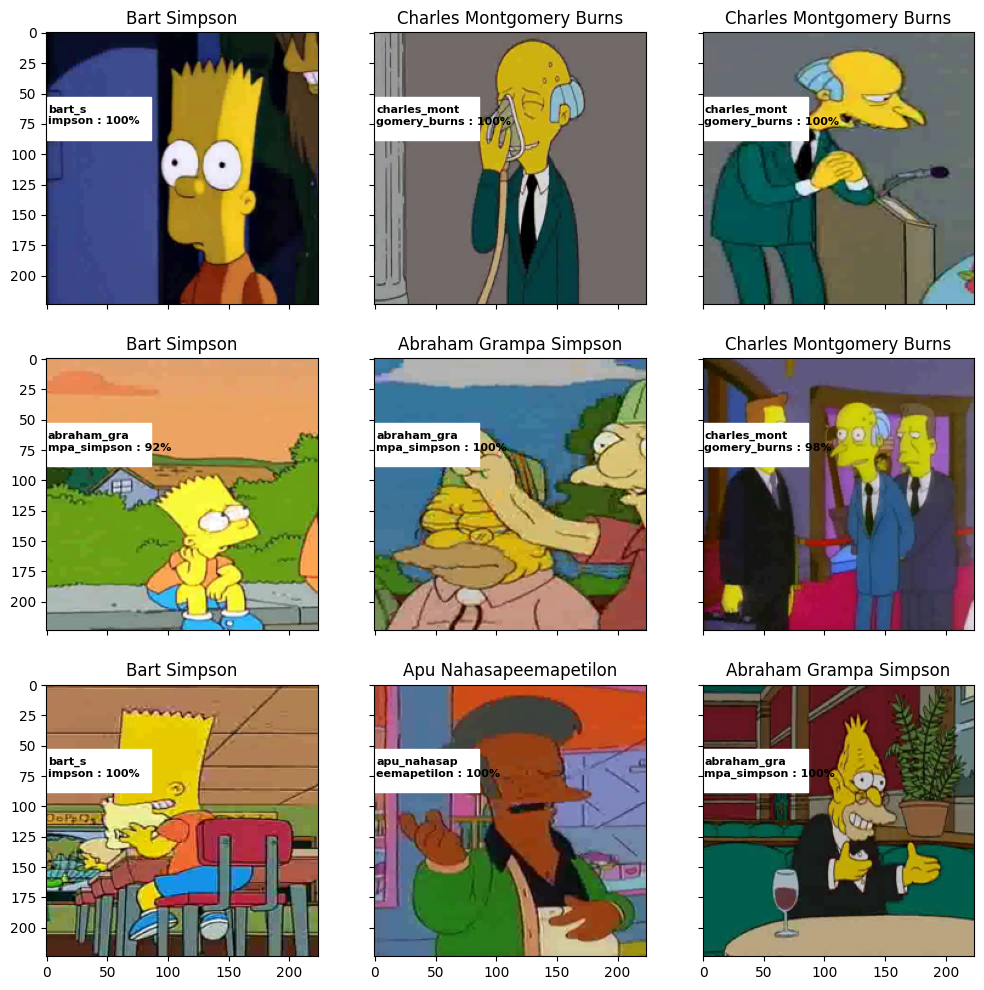

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [34]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [38]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [39]:
my_submit.to_csv('res_net_baseline.csv', index=False)

In [40]:
torch.save(model.state_dict(), 'resnet18_weights.pth')
